## Explanations for large language models

Created by: Sue-Ellen Bernadina, s1035357

In [1]:
!pip install datasets lime

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


# import datasets
from datasets import load_dataset


# for SHAP analysis
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score, r2_score, confusion_matrix, ConfusionMatrixDisplay
import shap
# shap.initjs()
from sklearn.ensemble import RandomForestClassifier
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import transformers


# import for LIME
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


# # IMPORT ATTENTION MAPS
# from transformers import AutoTokenizer, AutoModel, utils
# # from bertviz import model_view
# # utils.logging.set_verbosity_error()  # Suppress standard warnings
np.random.seed(1)

### Load dataset from huggingface

Found on [huggingface](https://huggingface.co/datasets/stanfordnlp/imdb/viewer/plain_text/test)

Other relevant work [this](http://huggingface.co/docs/transformers/model_doc/distilbert#transformers.TFDistilBertForSequenceClassification), [this](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#Explaining-a-transformers-NLP-model),

In [3]:
# help(datasets)

In [4]:
# from transformers import DistilBertModel

# dataset found on
# https://huggingface.co/datasets/sychonix/emotion/viewer/default/test?views%5B%5D=test

# Load emotion datas
dataset = load_dataset("emotion", split="test")
class_names = ["sadness", "joy", "love", "anger",  "fear", "surprise"]

# load data
data = pd.DataFrame({"text": dataset["text"], "emotion": dataset["label"]})

# change class labels
data['emotion'] = data['emotion'].apply(lambda x: class_names[x])

# split data
X_train, X_test, y_train, y_test = train_test_split(data.text, data.emotion, test_size=0.3, random_state=42)

TEXT_IND = 3

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# preview data
data.head(3)

text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness

## SHAP

Code has been based on [notebook 1](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#Explaining-a-transformers-NLP-model) and [notebook2](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html)


In [6]:
# tokenizer and  model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
shap_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(class_names))

# build a pipeline object to do predictions
pred = transformers.pipeline(
    "text-classification",
    model=shap_model,
    tokenizer=tokenizer,
    device=0,
    return_all_scores=True,
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [7]:
# create shap explainer
shap_exp = shap.Explainer(pred, output_names=class_names)

In [8]:
text = X_test.iloc[TEXT_IND]
print(text)

shap_values = shap_exp([text])

i have felt the need to write out my sometimes anxious feelings impatient thoughts lists of things that still should could be done before this baby arrives


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [02:30, 150.14s/it]              


In [9]:
# show shap text explanations
shap.plots.text(shap_values)

In [10]:

max_score = max(pred(text)[0], key=lambda x: x["score"])
predicted_class = max_score["label"]
predicted_class_actual = class_names[int(predicted_class.strip()[-1])]

# print(pred(text))
# print(predicted_class_actual)

print(f"Predicted label according to shap and score: {predicted_class_actual},  {max_score['score']} ")


Predicted label according to shap and score: love,  0.17771553993225098 


## LIME

Based on [notebook 3](https://medium.com/nlplanet/two-minutes-nlp-explain-predictions-with-lime-aec46c7c25a2) and [notebook 4](https://codesignal.com/learn/courses/introduction-to-modeling-techniques-for-text-classification/lessons/mastering-random-forest-for-text-classification)

Other relevant work:
[this](https://lime-ml.readthedocs.io/_/downloads/en/latest/pdf/)



In [11]:
# vectorize text
vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,2), stop_words="english", max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# train random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vec, y_train)

# create pipeline
pipeline = make_pipeline(vectorizer, rf)


In [12]:
# Make predictions on the test data
y_pred = rf.predict(X_test_vec)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy of Random Forest Classifier: {accuracy:.2f}")

Accuracy of Random Forest Classifier: 0.57


In [13]:
# lime explainer
lime_ = LimeTextExplainer(class_names=class_names)

# ind = 23
text = X_test.iloc[TEXT_IND]

print("Text:", text)
print("Actual label: ", y_test.iloc[TEXT_IND])


Text: i have felt the need to write out my sometimes anxious feelings impatient thoughts lists of things that still should could be done before this baby arrives
Actual label:  anger


In [14]:
exp1 = lime_.explain_instance(text, pipeline.predict_proba, num_features=6, top_labels=len(class_names))
# exp1.show_in_notebook(text=True)

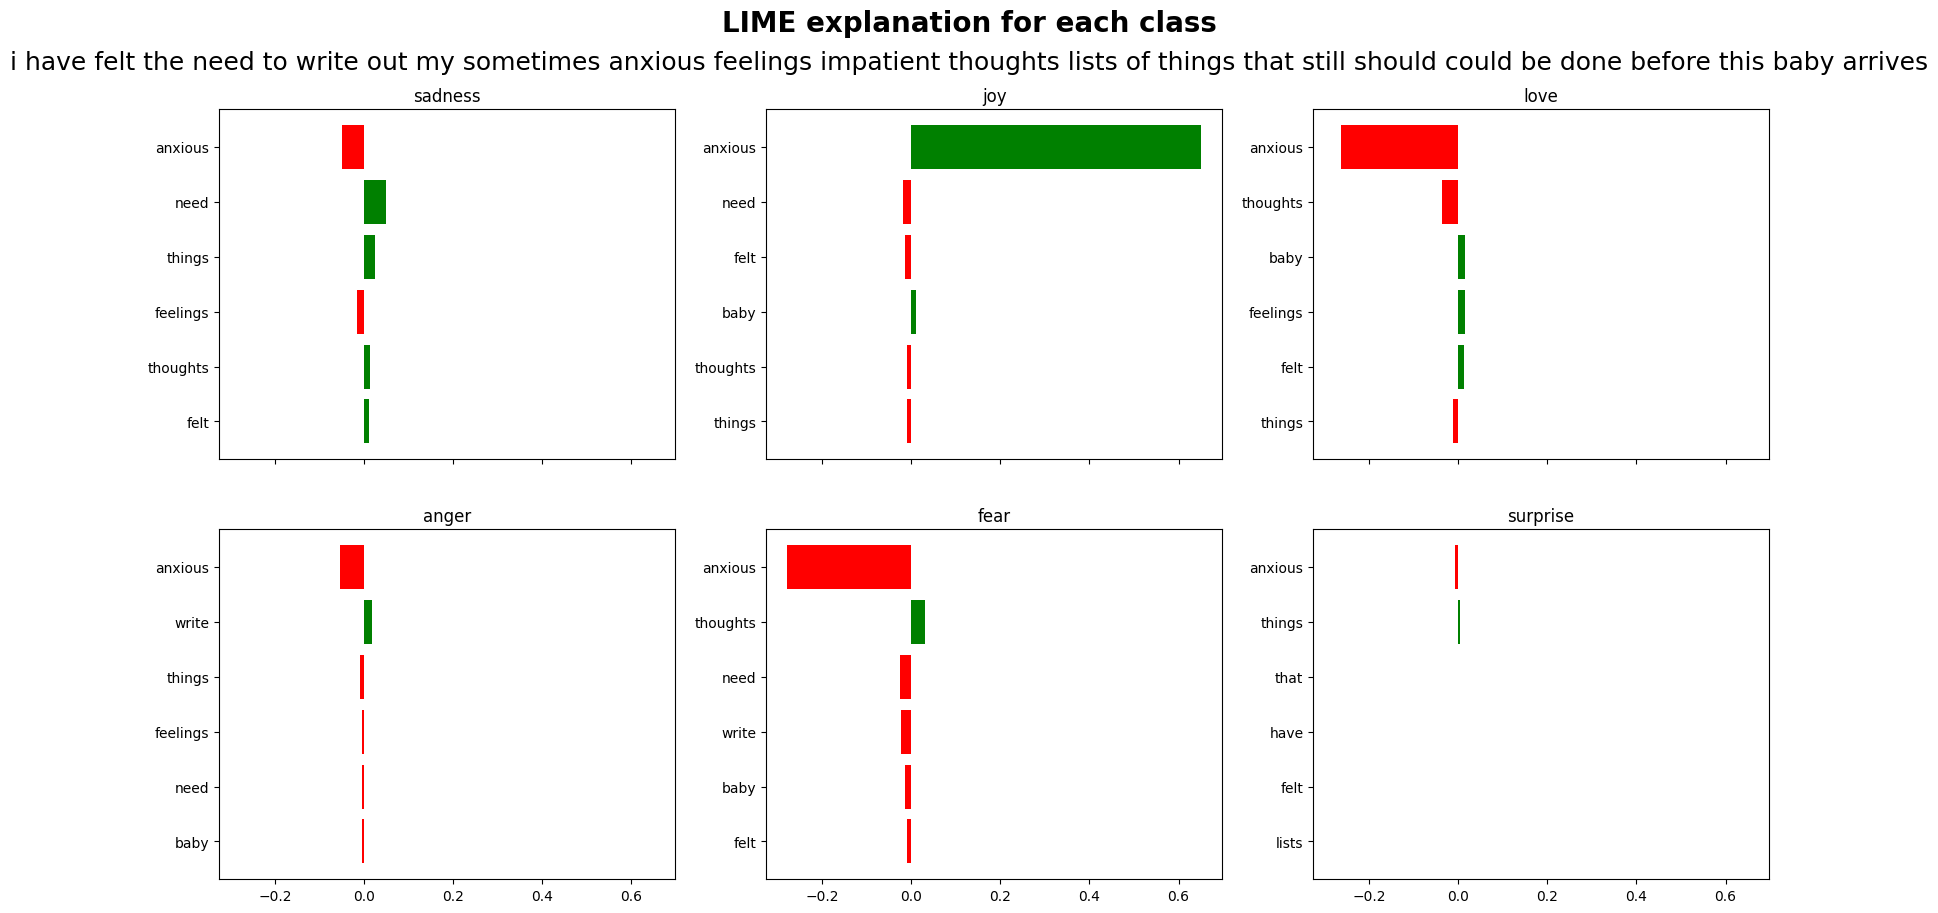

In [15]:
# plot LIME explanations for every  class

fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharex=True)
fig.suptitle("LIME explanation for each class", fontsize=20, fontweight='bold')

fig.text(0.5, 0.92, text, ha='center', fontsize=18)

# plot all classes
for i, label in enumerate(class_names):
    x , y = i//3, i%3
    try:

        exp_list = exp1.as_list(label=i)
        words, weights = zip(*exp_list)
        ax[x, y].barh(words, weights, color=['g' if w > 0 else 'r' for w in weights])
        ax[x, y].set_title(label)
        ax[x, y].invert_yaxis()
    except KeyError:
        ax[x, y].text(0.5, 0.5, f"ERROR! \nNo explanation for '{label}'",
                     ha='center', va='center', fontsize=12)
        ax[x, y].set_axis_off()

plt.show()


In [16]:
# plot lime explainer
exp1.show_in_notebook(text=True)

In [17]:
# preprocess text into vectors

# vectorize text
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words="english")
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# train random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vec, y_train)

RandomForestClassifier(random_state=42)

## Attention maps

Based on [notebook 5](https://www.kdnuggets.com/how-to-visualize-model-internals-and-attention-in-hugging-face-transformers) and [notebook 6](https://www.quora.com/How-do-I-plot-attention-heatmap-on-sentences-for-sentiment-analysis)

In [18]:
# create new bert model
model_name = "bhadresh-savani/bert-base-uncased-emotion"
model = transformers.AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


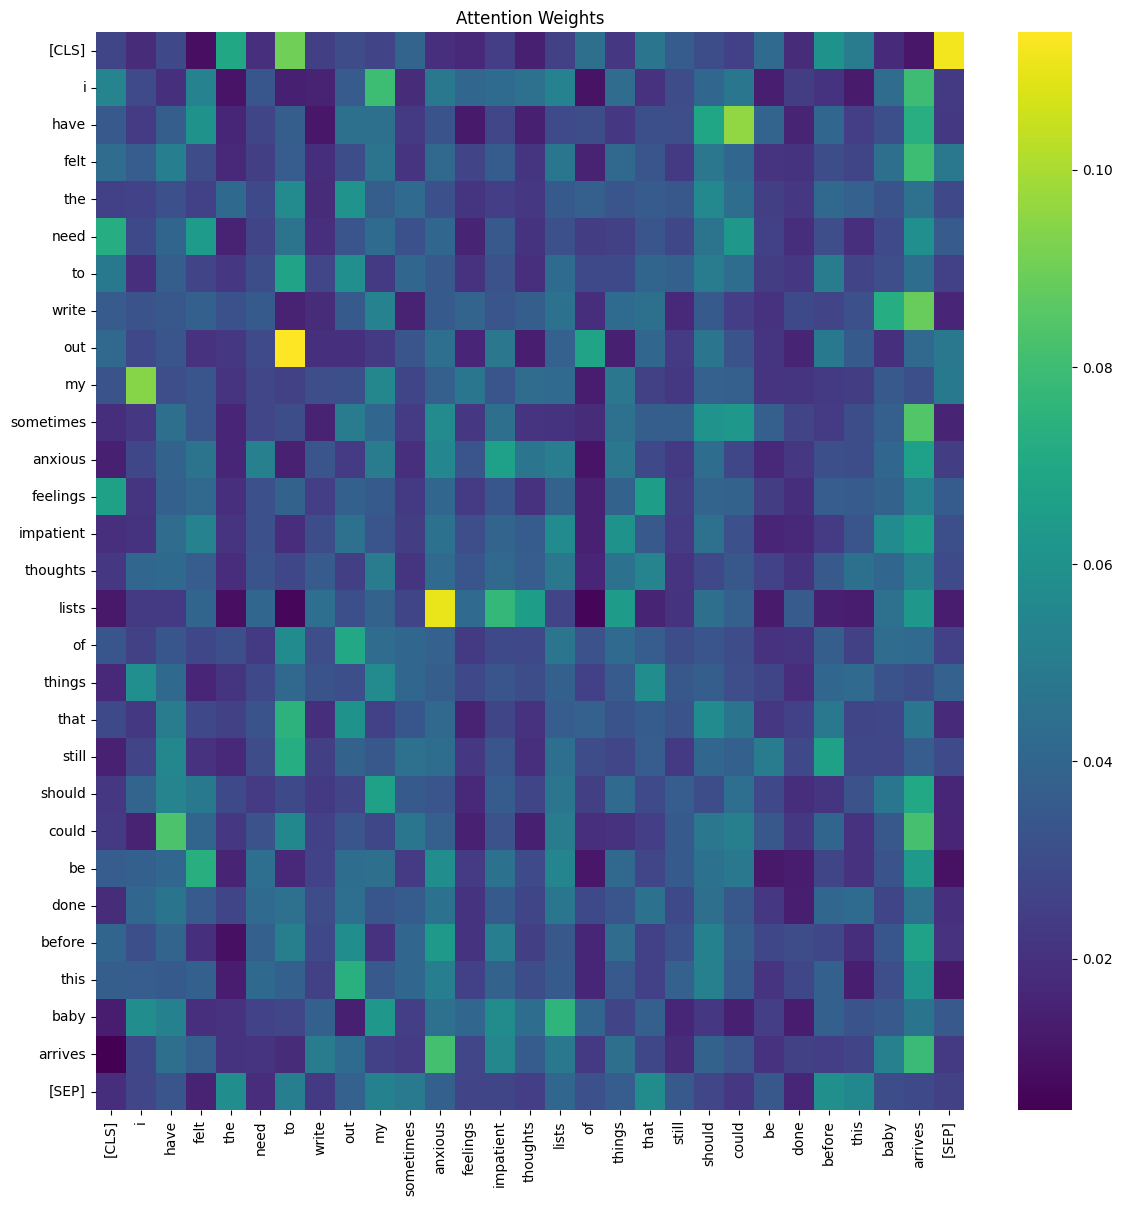

In [19]:
# tokenize and model outputs
input_text = X_test.iloc[TEXT_IND]

# get input and outputs
inputs = tokenizer(input_text, return_tensors='pt')
outputs = model(**inputs)

# extract attention layer
attention = outputs.attentions
attention_matrix = attention[0][0][0].detach().numpy()

# plot heatmap of attentions
plt.figure(figsize=(14, 14))
sns.heatmap(attention_matrix, xticklabels=tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
            yticklabels=tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]), cmap="viridis")
plt.title("Attention Weights")
# plt.savefig('plot.png')
plt.show()


In [20]:
!pip install bertviz

In [21]:
from bertviz import head_view
attention = outputs.attentions
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
# plt.figure()
head_view(attention, tokens)
# plt.savefig('head_view.png')
# plt.show()

<IPython.core.display.Javascript object>